In [12]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta



# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'
#Demographics File
DEMOGRAPHICS_FILE = 'data/Country_Demographics.csv'
DEMOGRAPHICS_BRZ_R_FILE = 'data/brz_region_demo.csv'

# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

#Data from Worldometers - https://www.worldometers.info/world-population/population-by-country/
demographics = pd.read_csv(DEMOGRAPHICS_FILE,
                 sep = ';',
                 encoding="ISO-8859-1",
                 dtype={"Country": str,
                        "Population": int},
                 error_bad_lines=False)


#variable to iterate on top for each country
country = ("Aruba,Afghanistan,Angola,Albania,Andorra,\
                United Arab Emirates,Argentina,Australia,Austria,\
                Azerbaijan,Burundi,Belgium,Benin,Burkina Faso,Bangladesh,\
                Bulgaria,Bahrain,Bahamas,Bosnia and Herzegovina,Belarus,\
                Belize,Bermuda,Bolivia,Brazil,Barbados,Brunei,Bhutan,\
                Botswana,Central African Republic,Canada,Switzerland,\
                Chile,China,Cote d'Ivoire,Cameroon,Democratic Republic of Congo,\
                Congo,Colombia,Comoros,Cape Verde,Costa Rica,Cuba,Cyprus,Czech Republic,\
                Germany,Djibouti,Dominica,Denmark,Dominican Republic,Algeria,Ecuador,Egypt,\
                Eritrea,Spain,Estonia,Ethiopia,Finland,Fiji,France,Faeroe Islands,\
                Gabon,United Kingdom,Georgia,Ghana,Guinea,Gambia,Greece,Greenland,\
                Guatemala,Guam,Guyana,Hong Kong,Honduras,Croatia,Haiti,Hungary,Indonesia,\
                India,Ireland,Iran,Iraq,Iceland,Israel,Italy,Jamaica,Jordan,Japan,Kazakhstan,\
                Kenya,Kyrgyz Republic,Cambodia,South Korea,Kuwait,Laos,Lebanon,Liberia,Libya,\
                Sri Lanka,Lesotho,Lithuania,Luxembourg,Latvia,Macao,Morocco,Monaco,Moldova,\
                Madagascar,Mexico,Mali,Malta,Myanmar,Mongolia,Mozambique,Mauritania,Mauritius,\
                Malawi,Malaysia,Namibia,Niger,Nigeria,Nicaragua,Netherlands,Norway,Nepal,New Zealand,\
                Oman,Pakistan,Panama,Peru,Philippines,Papua New Guinea,Poland,Puerto Rico,Portugal,\
                Paraguay,Palestine,Qatar,Kosovo,Romania,Russia,Rwanda,Saudi Arabia,Sudan,Senegal,\
                Singapore,Solomon Islands,Sierra Leone,El Salvador,San Marino,Somalia,Serbia,\
                South Sudan,Suriname,Slovak Republic,Slovenia,Sweden,Eswatini,Seychelles,Syria,\
                Chad,Togo,Thailand,Tajikistan,Turkmenistan,Timor-Leste,Tonga,Trinidad and Tobago,\
                Tunisia,Turkey,Taiwan,Tanzania,Uganda,Ukraine,Uruguay,United States,Uzbekistan,\
                Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Yemen,South Africa,Zambia,Zimbabwe")

In [13]:
df.set_index('CountryName').filter(like='Italy',axis=0) 
df=demographics.join(df.set_index('CountryName'),on='Country',how='inner',lsuffix='Country',rsuffix='CountryName')
 

In [39]:
CASES_COLUMNS = ["Country", "Population", "RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths"]


italy_data = df.query('Country == "Italy" \
                         & ConfirmedCases!=""\
                         & ConfirmedCases!="0"\
                         & ConfirmedCases!="NaN"')[CASES_COLUMNS]
 

### add time series
s = S/N , i = I/N, r = R/N
s+i+r = 1
I+R = ConfirmedCases + ConfirmedDeaths

In [624]:
# s = N-confirmedCases (assume population ins constant)
# need to check whether death needs to be removed
italy_data['s']=(italy_data['Population']-italy_data['ConfirmedCases'])/italy_data['Population']
#susceptible_list = italy_data['Population']-italy_data['ConfirmedCases']
#italy_data.loc[:,'Susceptible'] = pd.Series(susceptible_list, index=italy_data.index)
italy_data['NewInfected']= italy_data['ConfirmedCases'].diff()
italy_data['i'] =italy_data['ConfirmedCases']/italy_data['Population']

italy = np.zeros([italy_data.shape[0],2])
italy[0:,0] = np.arange(0,italy_data.shape[0]).astype(int)
italy[0:,1] = italy_data["i"]  


# start from day 200
np.savetxt("data/italy.csv", italy[200:  ,:], delimiter=",")

0.03386758448214912


In [625]:
# import SIR, ParticleSIR classes from models.py
from models import *

#Model Parameters
num_particles = 500#50
ens = num_particles
year = '2019-20'
file = 'italy' #CDC filename
path = 'Particle_Filter'

#date = np.array(['1','2'])
#date[0] = '2020-08-01'
#date[1] = '2020-08-04'
#path = '%s_%s_predictions_example' % (date[0],date[1])

#Set parameters  
params = {} #read_params('./data/params/params2019-20.csv')
params['alpha'] = .1  #beta 
params['beta'] =  0.03  # gamma
params['CDC'] = f'./data/{file}.csv'
params['filtering'] =True
params['time_varying'] =True
dat = get_data(params['CDC'])
params['epochs'] = dat.shape[0] #+ date_diff#   
params['init_i'] = dat[0]
#Created to flexibilize the amount of days


sir = ParticleSIR(num_particles, params)

initialize BaseSIR
call SIR.fit
alpha: 0.1
n epochs 132 epoch 0 refit True
intialize particle filter
initialize SIR
ParticleSIR initialized


132
./data/italy.csv
{'CORR': 0.9967068533405378,
 'MSPE': 0.03709905420362857,
 'RMSE': 0.0009552320086389519,
 'SSE': 0.00012044580112334968}


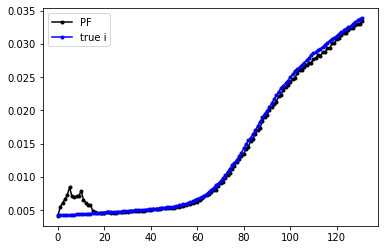

In [629]:
print(dat.shape[0])
print(params['CDC'])
sir.predict_with_filter(params)

pprint(sir.scores)


import matplotlib.pyplot as plt

x =   np.arange(0,len(sir.Is))
y = sir.IS
y_true =sir.CDC_obs

plt.plot(x,  y, '.-', color='black',label='PF');

plt.plot(x,y_true, '.-',color='blue',label='true i')
plt.legend()

0.0137987366140792
0.013907052866813195


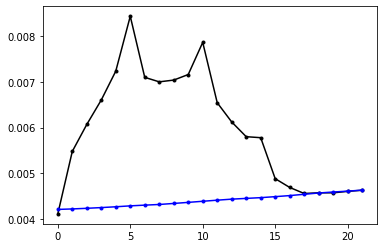

In [627]:
plt.plot(x[ :22],  y[:22], '.-', color='black');
plt.plot(x[:22],y_true[:22], '.-',color='blue')

print(np.mean(y))
print(np.mean(y_true))

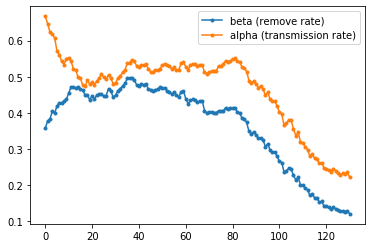

In [628]:
plt.plot(sir.beta_list,'.-',label='beta (remove rate)')
plt.plot(sir.alpha_list,'.-',label='alpha (transmission rate)')
plt.legend()